In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
#from specutils.fitting import find_lines_threshold, find_lines_derivative
#from scipy.optimize import curve_fit
#from astropy.stats import sigma_clip
from glob import glob
from scipy.signal import find_peaks
from specutils.manipulation import LinearInterpolatedResampler

# Load in data (downloaded in scratch.ipynb using MAST archive API)

In [2]:
spectrum_files = glob(os.path.join('HST','anonymous37222', '*.fits'))

In [193]:
# Load in RU Lupi data
#spectrum_files = glob(os.path.join('HST','mastDownload','HST','*','*x1dsum.fits'))

In [194]:
#spectrum_files = glob(os.path.join('HST','anonymous37141',"*cspec.fits"))

In [ ]:
INST_head = [fits.getheader(file, ext=0) for file in spectrum_files]
SCI_head = [fits.getheader(file, ext=1) for file in spectrum_files]
spectrum_x1d = [Table.read(file, hdu=1) for file in spectrum_files]

In [50]:
#date = [header['DATE-OBS'] for header in spectrum_header]
#observing_run = [header['ROOTNAME'] for header in spectrum_header]
instrument = [header['INSTRUME'] for header in spectrum_header_0]
#instrument_filter = [header['OPT_ELEM'] for header in spectrum_header_0]

In [ ]:
#from each spectrum, function to get specific lines OR specific transitions from France emission_lines.csv

lines = pd.read_csv('HST/emission_lines.csv', skiprows=2)
#lab_emission_lines = lines['lab_lambda']
#transition_grouped_lines = lines.groupby("[nu', J']")

In [ ]:
spectrum_x1d[0]

WAVELENGTH,FLUX,ERROR,SNR,EFF_EXPTIME
Angstrom,erg / (Angstrom s cm2),erg / (Angstrom s cm2),,s
float32[59914],float32[59914],float32[59914],float32[59914],float32[59914]
1135.6062 .. 1795.7308,-9.243304e-17 .. 3.5043925e-14,8.496804e-16 .. 9.7835134e-15,-0.10878565 .. 3.5819366,1199.168 .. 1382.176


In [ ]:
file_idx = 5
flux_units = (u.erg/(u.AA*u.s*(u.cm**-2)))

x1d_wavelength = np.ravel(spectrum_x1d[file_idx]['WAVELENGTH'])
#wavesort_idx = np.argsort(x1d_wavelength)
#x1d_wavelength = x1d_wavelength[wavesort_idx]

x1d_flux = np.ravel(spectrum_x1d[file_idx]['FLUX'])
x1d_fluxerr = np.ravel(spectrum_x1d[file_idx]['ERROR'])

#x1d_flux = x1d_flux[wavesort_idx]
#x1d_fluxerr = x1d_fluxerr[wavesort_idx]

In [ ]:
# spectrum = Spectrum1D(flux = x1d_flux, spectral_axis=x1d_wavelength)
# x1d_lines = find_lines_derivative(spectrum) #noise_factor is the threshold (x*flux error)
# x1d_emissions = x1d_lines[x1d_lines['line_type']=='emission']

In [ ]:
peaks , _ = find_peaks(np.array(x1d_flux), height=max(x1d_fluxerr.value)*2, distance=100)

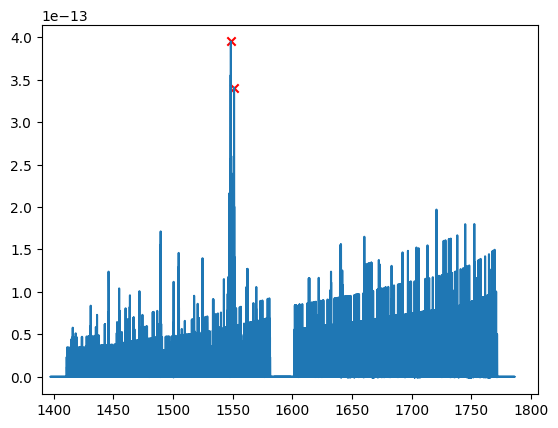

In [ ]:
plt.plot(x1d_wavelength,x1d_flux)
plt.scatter(x1d_wavelength[peaks], x1d_flux[peaks], c='red', marker='x')
plt.xlim(left=1390)
plt.show()

In [ ]:
#Find the emission lines associated with H2 fluorescence
emission_table_idx = []
lab_line_row = []
for i, l in enumerate(lines['lab_lambda']):
    diff = abs(x1d_wavelength[peaks]/u.AA-l)
    if min(diff) < 5:
        emission_table_idx.append(np.argmin(diff))
        lab_line_row.append(lines.iloc[i])

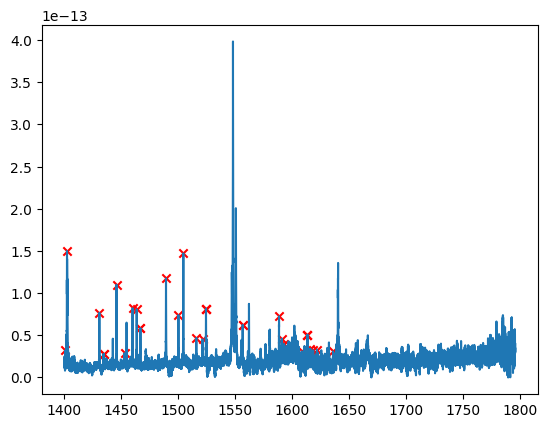

In [ ]:
plt.scatter(np.array(x1d_wavelength[peaks])[emission_table_idx], np.array(x1d_flux[peaks])[emission_table_idx], c='r', marker='x')
plt.plot(x1d_wavelength,x1d_flux)
#plt.xlim(left=1380)
plt.show()

In [ ]:
line_width = 150
x1d_h2_emissions_idx = np.array(peaks)[emission_table_idx]
x1d_h2_emissions_flux = [x1d_flux[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_fluxerr = [x1d_fluxerr[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]
x1d_h2_emissions_wavelength = [x1d_wavelength[idx-line_width:idx+line_width] for idx in x1d_h2_emissions_idx]

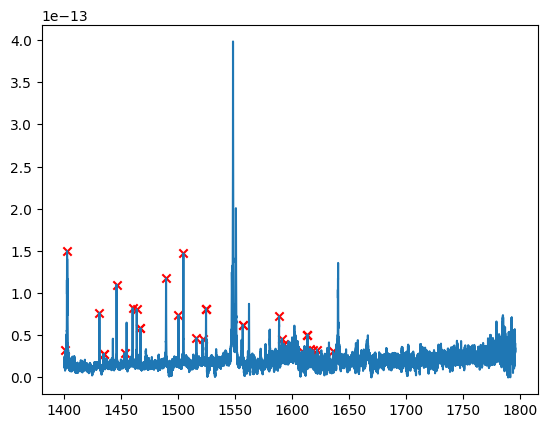

In [ ]:
plt.scatter(np.array(x1d_wavelength)[x1d_h2_emissions_idx], np.array(x1d_flux)[x1d_h2_emissions_idx], c='r', marker='x')
plt.plot(x1d_wavelength, x1d_flux)
plt.xlim(left=1380)
plt.show()

In [ ]:
colnames = ['Line ID', "[nu', J']", "lab_lambda", "spec_flux", "spec_fluxerr", "spec_wavelength"]

line_ID = np.array(lab_line_row)[:, 0]
nu_J = np.array(lab_line_row)[:, 1]
lab_lambda = np.array(lab_line_row)[:, 2]

# Ensure all are 1D numpy arrays or lists of same length
line_ID = np.asarray(line_ID)
nu_J = np.asarray(nu_J)
lab_lambda = np.asarray(lab_lambda)
flux = x1d_h2_emissions_flux
fluxerr = x1d_h2_emissions_fluxerr
wavelength = x1d_h2_emissions_wavelength

# Combine row-wise
data = list(zip(line_ID, nu_J, lab_lambda, flux, fluxerr, wavelength))
spectrum_df = pd.DataFrame(data, columns=colnames)

In [ ]:
spectrum_df.index = spectrum_df["[nu', J']"]
spectrum_df

,Line ID,"[nu', J']",lab_lambda,spec_flux,spec_fluxerr,spec_wavelength
"[nu', J']",,,,,,
"[3,13]",(3–9)P(14),"[3,13]",1608.33,[1.7703417196286188e-14 cm2 erg / (Angstrom s)...,[3.3116178205840627e-15 cm2 erg / (Angstrom s)...,"[1606.56494140625 Angstrom, 1606.5772705078125..."
"[3,13]",(3–10)R(12),"[3,13]",1615.43,"[2.078932254752537e-14 cm2 erg / (Angstrom s),...",[2.9581416543324234e-15 cm2 erg / (Angstrom s)...,"[1614.133056640625 Angstrom, 1614.145385742187..."
"[4,13]",(4–11)R(12),"[4,13]",1613.99,"[5.487166676706925e-15 cm2 erg / (Angstrom s),...",[1.8634191208837837e-15 cm2 erg / (Angstrom s)...,"[1611.4757080078125 Angstrom, 1611.48791503906..."
"[3,16]",(3–7)R(15),"[3,16]",1513.99,[1.9793437112318284e-14 cm2 erg / (Angstrom s)...,[1.8945835805956376e-15 cm2 erg / (Angstrom s)...,"[1513.959716796875 Angstrom, 1513.972045898437..."
"[3,16]",(3–9)R(15),"[3,16]",1593.26,"[3.643838838518834e-14 cm2 erg / (Angstrom s),...","[3.618663240557247e-15 cm2 erg / (Angstrom s),...","[1591.036865234375 Angstrom, 1591.049194335937..."
"[3,16]",(3–10)R(15),"[3,16]",1621.12,[1.8693229405261462e-14 cm2 erg / (Angstrom s)...,[2.8322530766126475e-15 cm2 erg / (Angstrom s)...,"[1619.9132080078125 Angstrom, 1619.92553710937..."
"[4,4]",(4–9)P(5),"[4,4]",1526.55,[2.3042643639524518e-14 cm2 erg / (Angstrom s)...,"[2.075113618468078e-15 cm2 erg / (Angstrom s),...","[1522.4462890625 Angstrom, 1522.4586181640625 ..."
"[4,4]",(4–11)P(5),"[4,4]",1613.72,"[5.487166676706925e-15 cm2 erg / (Angstrom s),...",[1.8634191208837837e-15 cm2 erg / (Angstrom s)...,"[1611.4757080078125 Angstrom, 1611.48791503906..."
"[1,7]",(1–6)P(8),"[1,7]",1467.08,[2.2690731943126458e-14 cm2 erg / (Angstrom s)...,[1.8396350709995934e-15 cm2 erg / (Angstrom s)...,"[1464.8773193359375 Angstrom, 1464.88952636718..."


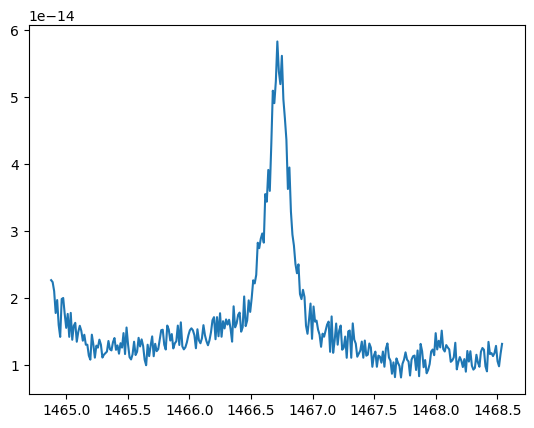

In [ ]:
transition='[0,3]'
plt.plot(np.hstack(spectrum_df['spec_wavelength'][transition]), np.hstack(spectrum_df['spec_flux'][transition]))

# Do this for every file, just keep the line centers though. Making it a function

In [2]:
#import seaborn as sns
#from matplotlib import cycler
import matplotlib as mpl
#clrs = sns.color_palette('Set1')
#clrs[5] = (255/255, 200/255, 80/255)
#colors = cycler('color', list(clrs.as_hex()))
mpl.rc('font', family='serif')
mpl.rc('text', usetex=False)

plt.rc('axes', axisbelow=True, 
       grid=False)#, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
#plt.rcParams['figure.dpi'] = 300

In [472]:
#Keep units for future math
class spectrum():
    def __init__(self, files):
        """
        Initialize spectrum, unpack spectra into useable arrays
        
        Parameters:
        - files: a list of .fits files from HST, each with a header hdu, and a spectrum BinTable hdu
        """
        self.flux_units = (u.erg/(u.AA*u.s*(u.cm**2)))
        self.wavelength_units = u.AA
        self.linelist = None
        #construct dataframe with filename, relevant header information, and spectrum information for each file.
        #Then add to a list of dataframes from files
        rows = []
        for file in files:
            #Use np.ravel here because the wavelength in the table  is a list in one table cell (e.g. [[1, 2, 3]])
            INST_head = fits.getheader(file, ext=0)
            SCI_head = fits.getheader(file, ext=1)
            spectrum_x1d = Table.read(file, hdu=1)
            
            self.x1d_wavelength = np.ravel(spectrum_x1d['WAVELENGTH'])/self.wavelength_units
            self.x1d_flux = np.ravel(spectrum_x1d['FLUX'])/self.flux_units
            self.x1d_fluxerr = np.ravel(spectrum_x1d['ERROR'])/self.flux_units
            if "cspec" in file:
                date = SCI_head['DATE-BEG'][:10]
            elif "x1dsum" in file:
                date = SCI_head['DATE-OBS']
            instrument = INST_head['INSTRUME']
            try:
                instrument_filter = INST_head['OPT_ELEM']
            except KeyError:
                instrument_filter = INST_head['GRATING'] #in cspec header
            df_data = {'filename':file, 
                       'obsdate':date,
                       'instrument':instrument, 
                       'filter':instrument_filter, 
                       'wavelength':self.x1d_wavelength*self.wavelength_units, 
                       'flux': self.x1d_flux*self.flux_units, 
                       'fluxerr':self.x1d_fluxerr*self.flux_units}
            rows.append(pd.Series(df_data))
        self.spec_df = pd.DataFrame(rows)
        drop_idx = []
        for i in range(len(self.spec_df)-1):
            if len(self.spec_df.iloc[i]['wavelength'])<1:
                drop_idx.append(i)
        self.spec_df.drop(labels=drop_idx, inplace=True)
        self.spec_df.reset_index(drop=True, inplace=True)
        self.spec_df['obsdate'] = self.spec_df['obsdate'].astype(str)

    def coaddwave(self, group):
        """
        Co-add spectra using the spectrum1D function.

        Parameters:
        - grouped dataframe (e.g. by date and by filter)

        Returns:
        - coadded_spectrum: spectrum dictionary
        """
        resampler = LinearInterpolatedResampler(extrapolation_treatment='zero_fill')
        wavelengths = group['wavelength'].values
        fluxes = group['flux'].values
        fluxerrs = group['fluxerr'].values
        base_wave = wavelengths[0]
        spectra = []

        for wave, flux, err in zip(wavelengths, fluxes, fluxerrs):
            wavesort_idx = np.argsort(wave)
            spec = Spectrum1D(spectral_axis=wave[wavesort_idx], flux=flux[wavesort_idx], uncertainty=StdDevUncertainty(err[wavesort_idx]))
            spec_resampled = resampler(spec, np.sort(base_wave))
            spectra.append(spec_resampled)

        coadded = np.sum(spectra)
        coadd_wave = coadded.wavelength
        coadd_flux = coadded.flux
        coadd_err = coadded.uncertainty.quantity.to(self.flux_units)
        spec_dict = {'wavelength': coadd_wave, 'flux':coadd_flux, 'fluxerr': coadd_err}

        return spec_dict
    
    def H2lines_fromspectrum(self, df, linelist):
        """
        Get the H2 line peaks from the spectrum, and add the peaks to the spectrum dataframe

        Parameters:
        - linelist: an array of

        Returns:
        - Line peak indices and the associated transitions added to the original dataframe
        """
        df['H2line_idx'] = None
        df["[nu', J']"] = None
        for i in range(len(df)):
            row = df.iloc[i]
            peaks , _ = find_peaks(np.array(row['flux'].value), height=np.array(row['fluxerr'].value)*2, distance=50)
            
            #Find the emission lines associated with H2 fluorescence
            emission_table_idx = []
            nu_J = []
            if len(peaks)>=0.5:
                for il, l in enumerate(linelist['lab_lambda']):
                    diff = abs(row['wavelength'][peaks]/u.AA-l)
                    if min(diff) <= 2:
                        emission_table_idx.append(np.argmin(diff))
                        nu_J.append(linelist['[nu\', J\']'].iloc[il])
            else:
                pass
            df.at[i, 'H2line_idx'] = np.array(peaks)[emission_table_idx]
            df.at[i, "[nu', J']"] = nu_J
        return df

    #next step is to coadd full spectra and then get line properties

# Initialize spectrum class with HST files
The data is interesting, I don't have older data, and the cspec files are weird.

In [473]:
x1dsum_files = glob(os.path.join('HST', 'anonymous37222', '*x1dsum.fits'))
cspec_files = glob(os.path.join('HST','anonymous37222',"*cspec.fits"))
spectrum_files = np.hstack([x1dsum_files, cspec_files])
all_spectra = spectrum(spectrum_files)

In [474]:
all_spectra.spec_df['filter'].unique()

array(['G130M', 'G160M', 'G230L', 'G130M-G160M', 'G160M-G230L',
       'E140M-G430L', 'E140M', 'G430L'], dtype=object)

In [475]:
linelist = pd.read_csv('HST/emission_lines.csv', skiprows=2)

In [476]:
#coadd per date
res = all_spectra.spec_df.groupby(['obsdate', 'filter']).apply(all_spectra.coaddwave, include_groups=False)

In [477]:
stacked_wave = []
stacked_flux = []
stacked_fluxerr = []
date = np.array(res.index.get_level_values('obsdate'))
filter = np.array(res.index.get_level_values('filter'))
for i in range(len(res.values)):
    stacked_wave.append(res.values[i]['wavelength'])
    stacked_flux.append(res.values[i]['flux'])
    stacked_fluxerr.append(res.values[i]['fluxerr'])
stacked_df = pd.DataFrame({'obsdate':date, 'filter':filter, 'wavelength':stacked_wave, 'flux':stacked_flux, 'fluxerr':stacked_fluxerr})

In [478]:
all_spectra.H2lines_fromspectrum(stacked_df, linelist)

,obsdate,filter,wavelength,flux,fluxerr,H2line_idx,"[nu', J']"
0,2000-07-12,E140M,"[1140.497314453125 Angstrom, 1140.515747070312...",[-1.0063107985791575e-10 erg / (Angstrom s cm2...,[1.2589298669985872e-10 erg / (Angstrom s cm2)...,"[25431, 25777, 14945, 20006, 25689, 15052, 202...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16..."
1,2000-07-12,E140M-G430L,"[1141.602294921875 Angstrom, 1141.620727539062...",[-3.6165768730472836e-12 erg / (Angstrom s cm2...,[1.1043683830069503e-12 erg / (Angstrom s cm2)...,"[25371, 25717, 14885, 19946, 25629, 14992, 202...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16..."
2,2000-07-12,G430L,"[2985.4638671875 Angstrom, 2988.208984375 Angs...","[2.711684772126882e-13 erg / (Angstrom s cm2),...",[3.5418607755334342e-15 erg / (Angstrom s cm2)...,[],[]
3,2011-07-20,G130M,"[1124.7185766387568 Angstrom, 1124.72853832954...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[31744, 28522, 28891, 28159, 29353]","[[1,4], [0,1], [0,2], [0,3], [0,3]]"
4,2011-07-20,G160M,"[1386.0412954067515 Angstrom, 1386.05353027634...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19614, 10072, 19614, 10463, 17927, 7428, 1152...","[[3,13], [4,13], [4,13], [3,16], [3,16], [4,4]..."
5,2012-02-28,G130M,"[1124.9096635174221 Angstrom, 1124.91962690073...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[30139, 30456, 31739, 32095, 28518, 28891, 320...","[[4,13], [3,16], [1,4], [3,0], [0,1], [0,2], [..."
6,2012-02-28,G130M-G160M,"[1135.606201171875 Angstrom, 1135.616088867187...",[-1.8486607893877392e-16 erg / (Angstrom s cm2...,[1.2016295477250441e-15 erg / (Angstrom s cm2)...,"[44616, 45181, 28048, 36525, 45090, 28309, 368...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16..."
7,2012-02-28,G160M,"[1386.2769487823698 Angstrom, 1386.28918573199...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19175, 19697, 2391, 10040, 19629, 2584, 10462...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16..."
8,2021-08-10,G160M,"[1385.9946471407397 Angstrom, 1386.00688689571...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19192, 19737, 2424, 10125, 19597, 2620, 10481...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16..."
9,2021-08-10,G160M-G230L,"[1395.537109375 Angstrom, 1395.54931640625 Ang...",[1.9165435026762684e-14 erg / (Angstrom s cm2)...,"[7.076723097130613e-15 erg / (Angstrom s cm2),...","[17387, 17932, 1609, 9289, 17792, 1888, 9675, ...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16..."


# Some code to investigate fluxerr and flux in the spectrum and how it affects peak finding

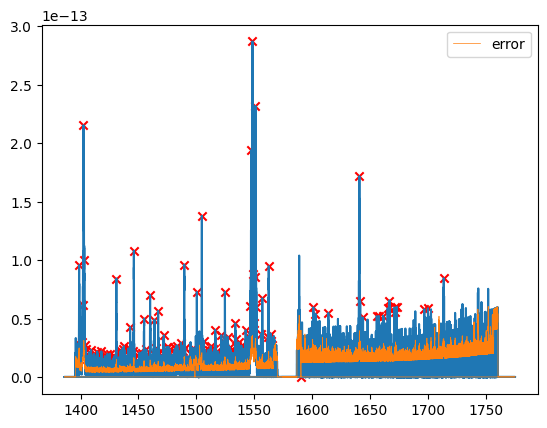

In [ ]:
date_filter = all_spectra.spec_df['obsdate']=='2022-08-14'

flux = all_spectra.spec_df.loc[date_filter, 'flux'].values[0].value
fluxerr = all_spectra.spec_df.loc[date_filter, 'fluxerr'].values[0].value
wavelength = all_spectra.spec_df.loc[date_filter, 'wavelength'].values[0].value

peaks, _ = find_peaks(flux, height=fluxerr*2, distance=50)
#print(peaks)
plt.plot(wavelength, flux)
plt.scatter(wavelength[peaks], flux[peaks], c='red', marker='x')
#plt.hlines(np.mean(fluxerr[flux>0]), min(wavelength), max(wavelength), 'r','--')
plt.plot(wavelength, fluxerr, lw=0.5, label='error')
plt.legend()
#plt.xlim(left=1390)
plt.show()

In [471]:
stacked_df.iloc[57]['wavelength'][stacked_df.iloc[57]['H2line_idx']]

<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [] Angstrom>

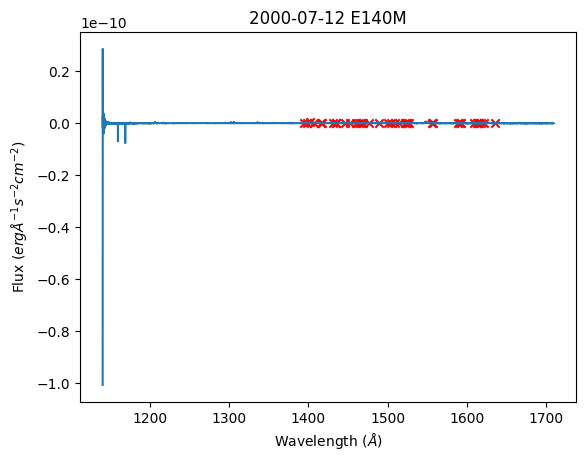

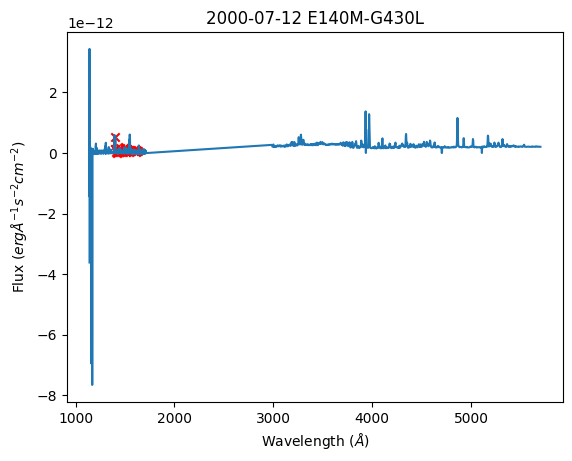

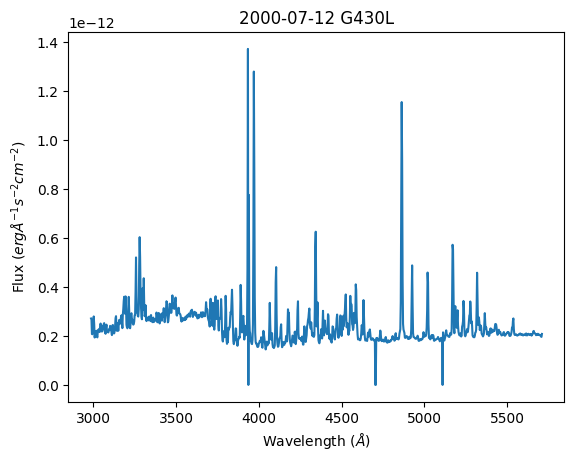

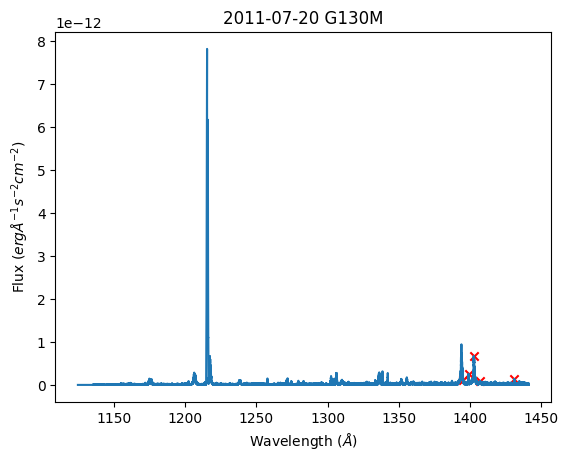

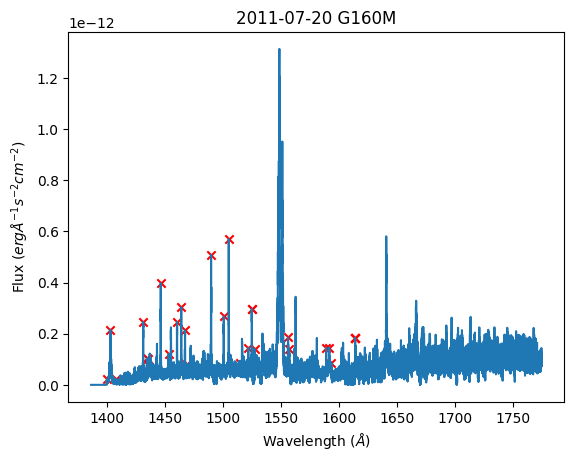

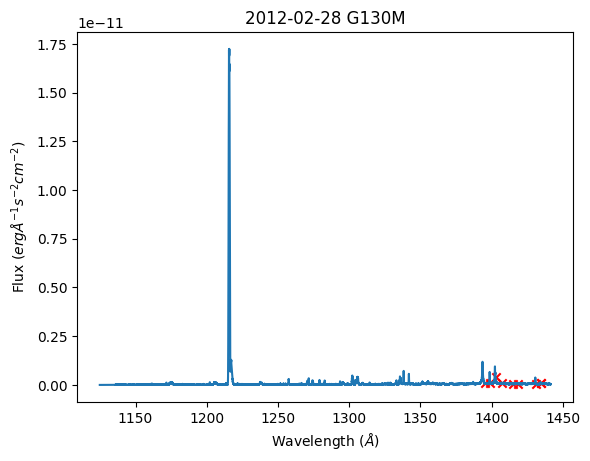

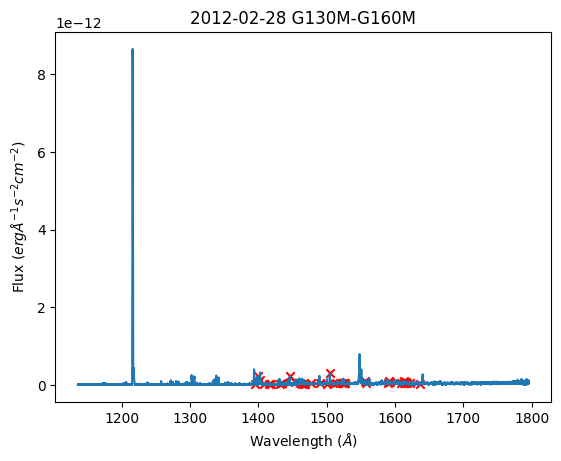

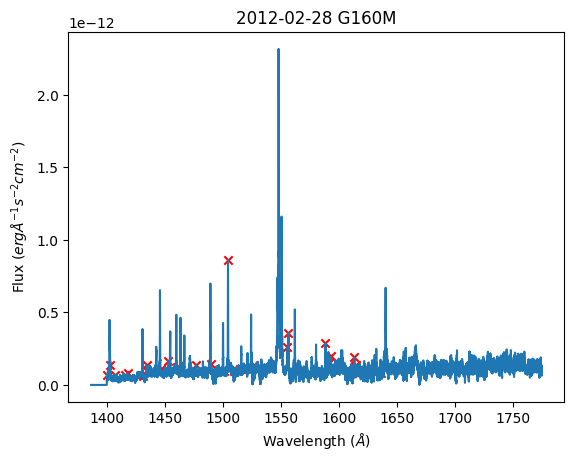

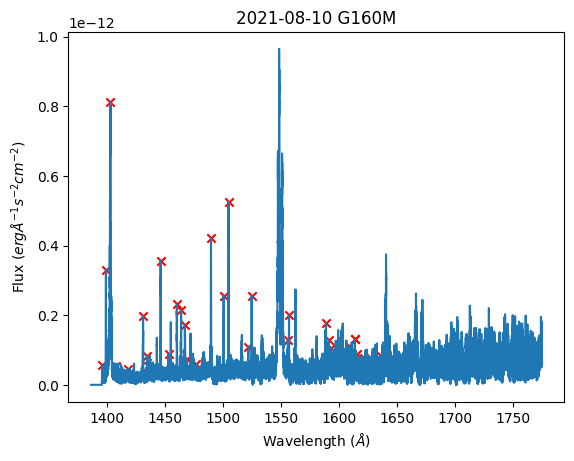

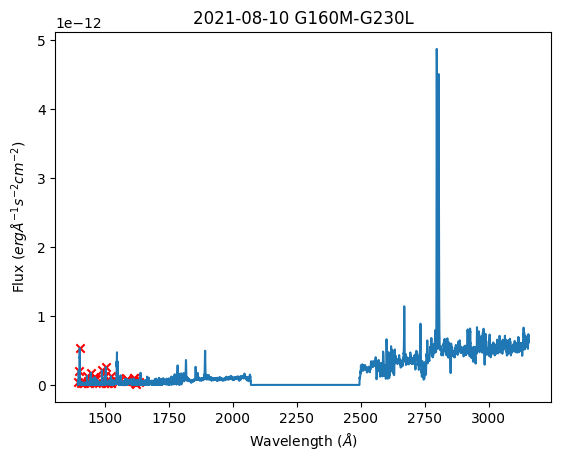

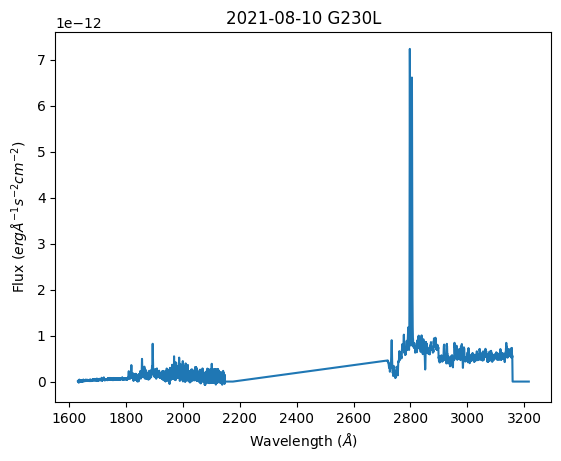

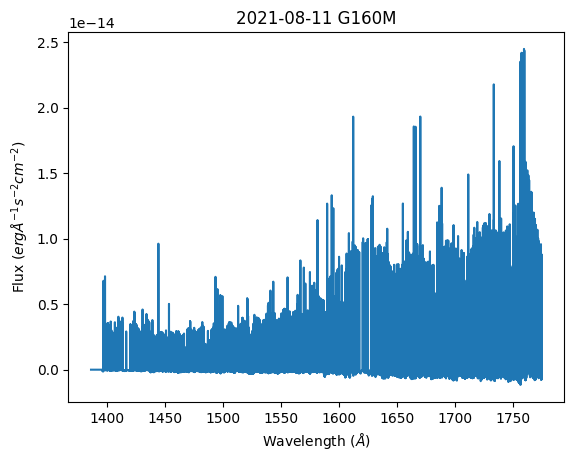

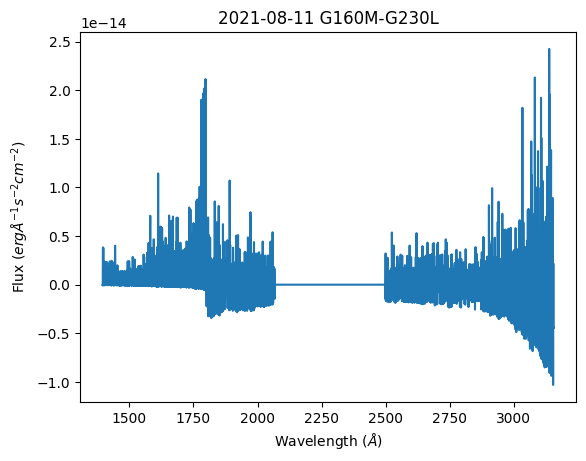

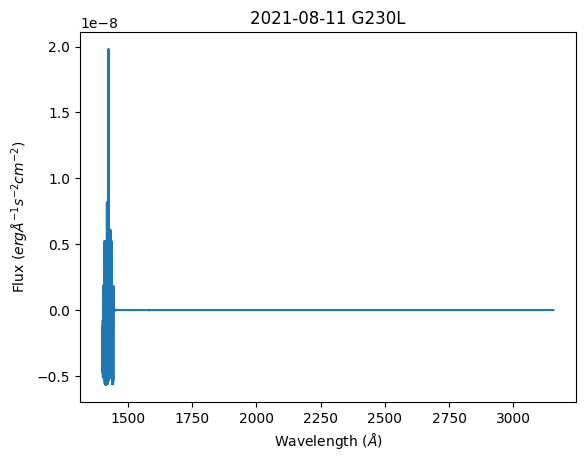

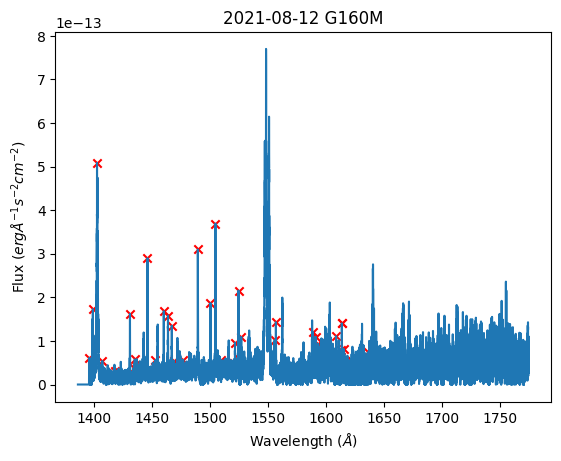

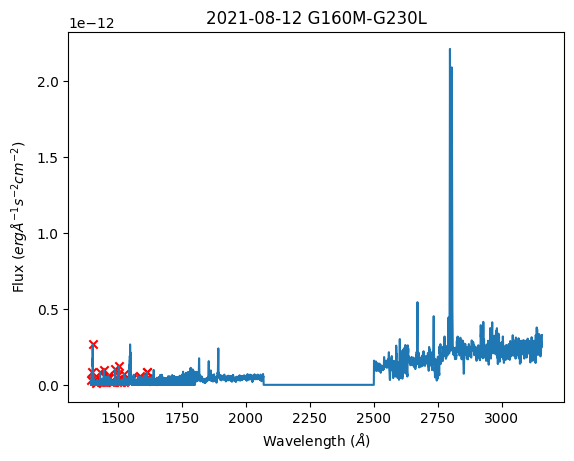

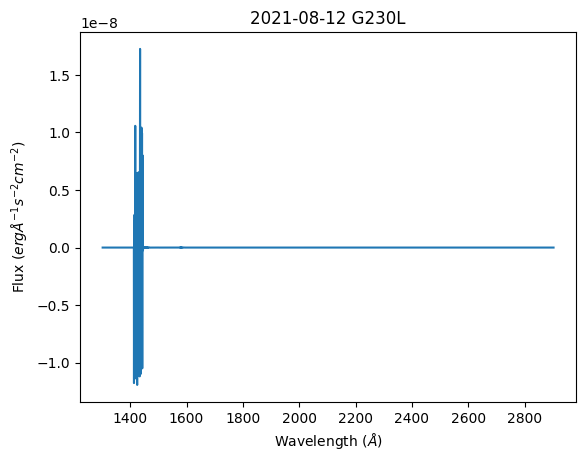

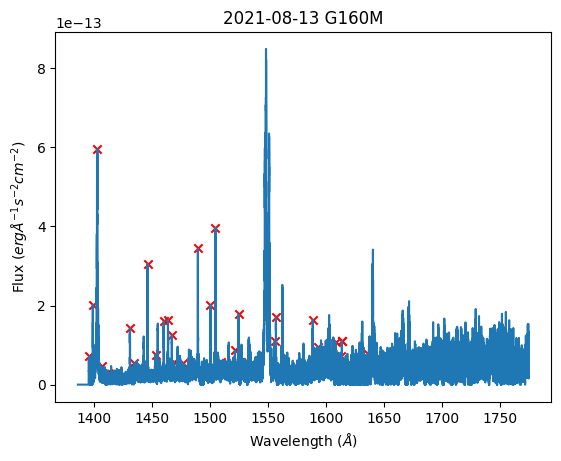

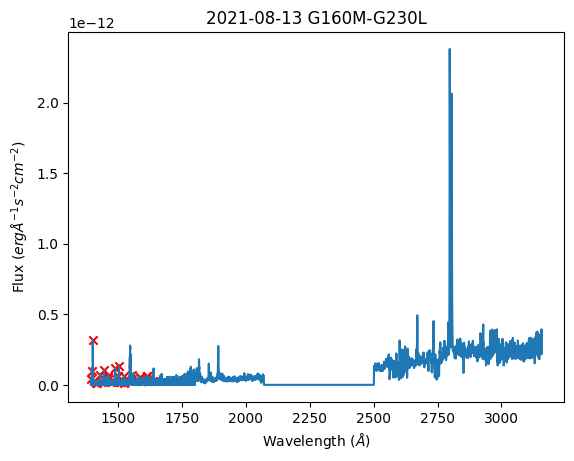

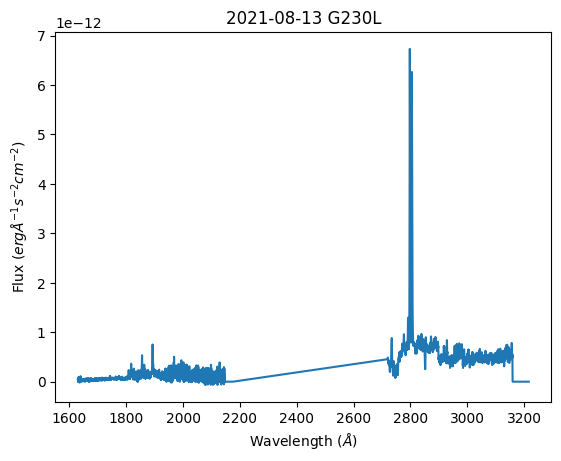

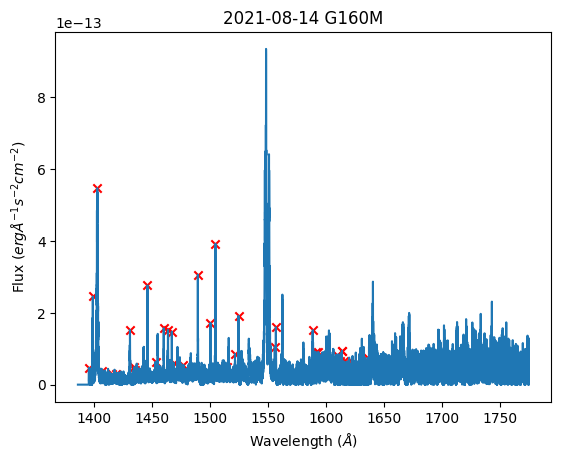

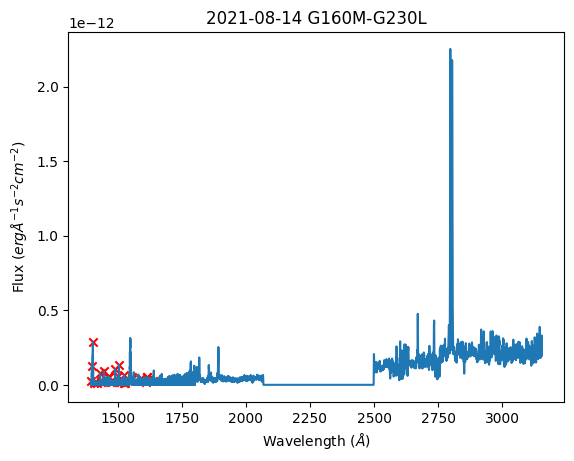

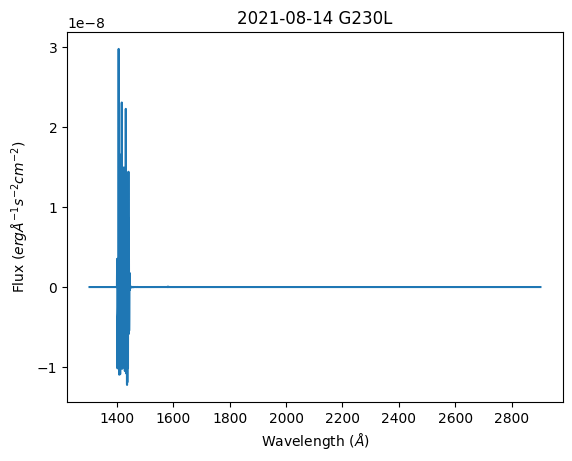

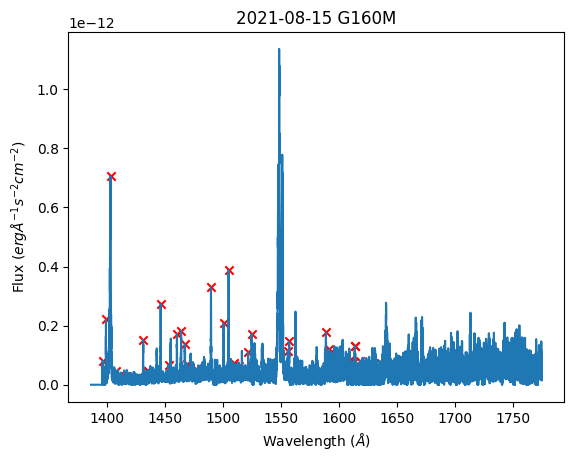

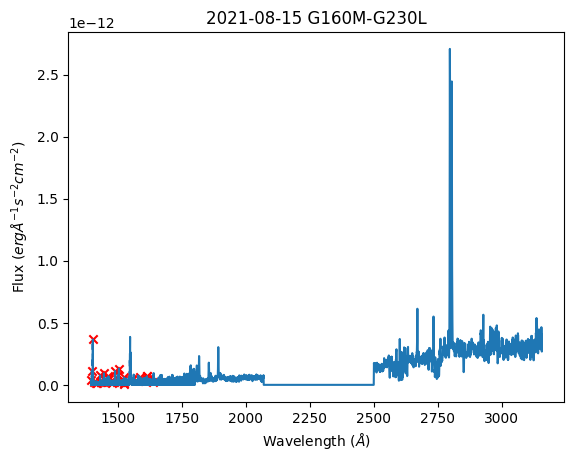

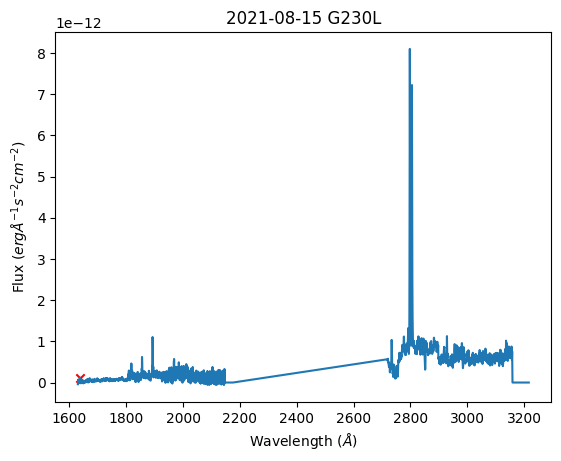

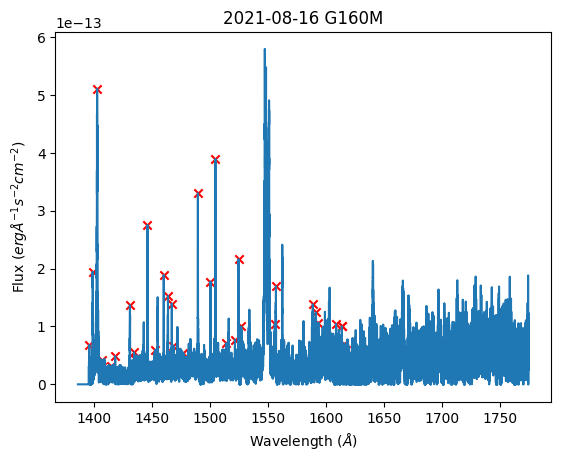

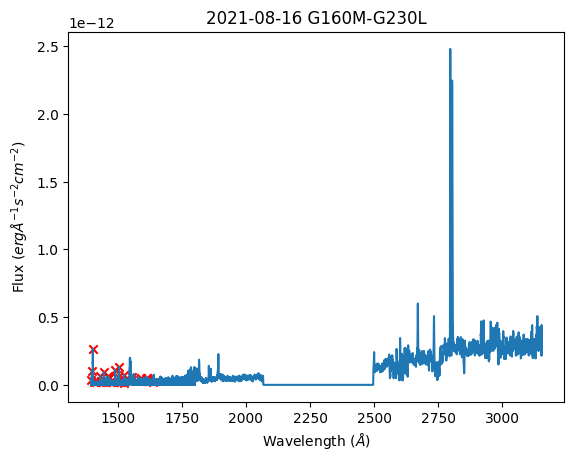

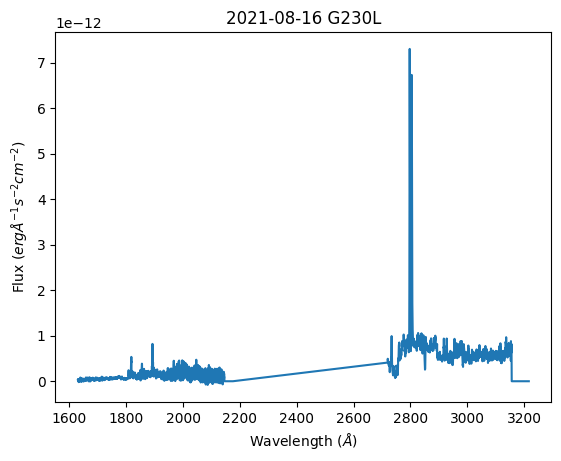

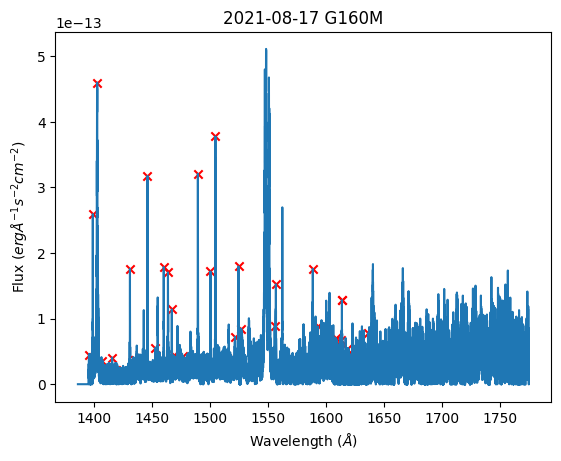

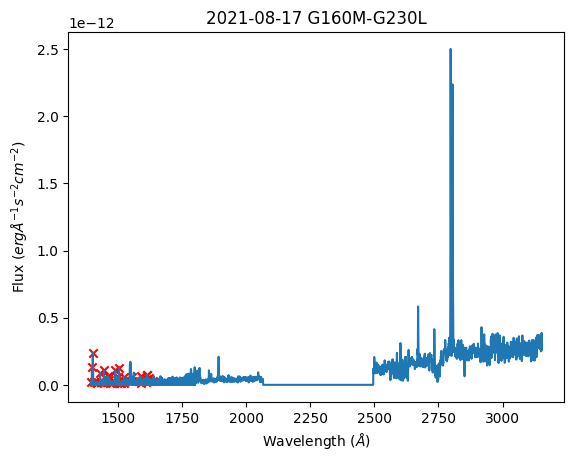

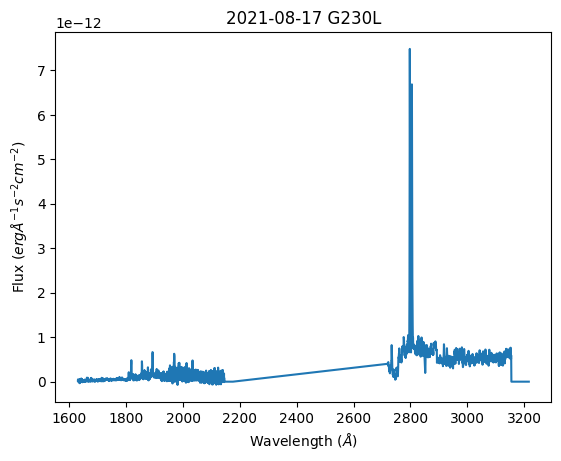

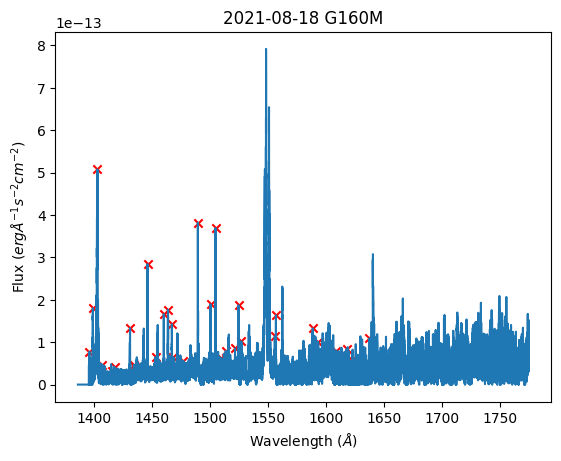

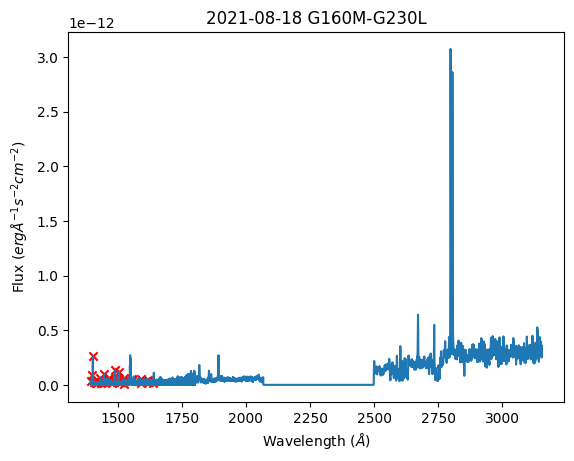

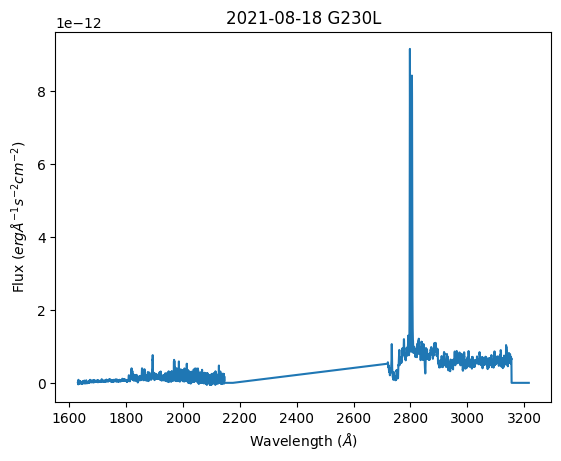

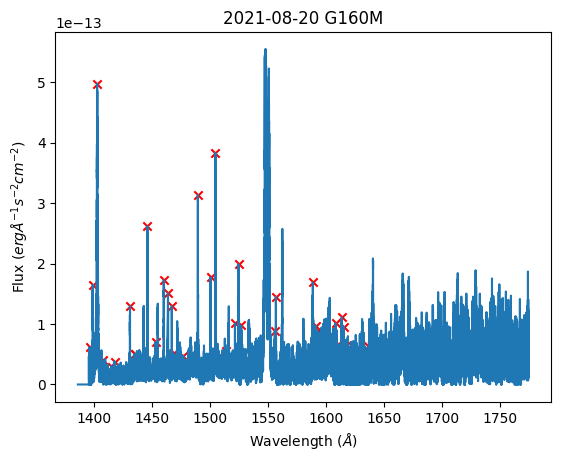

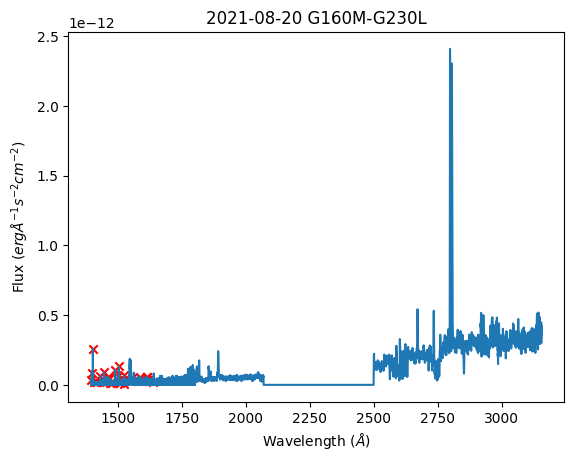

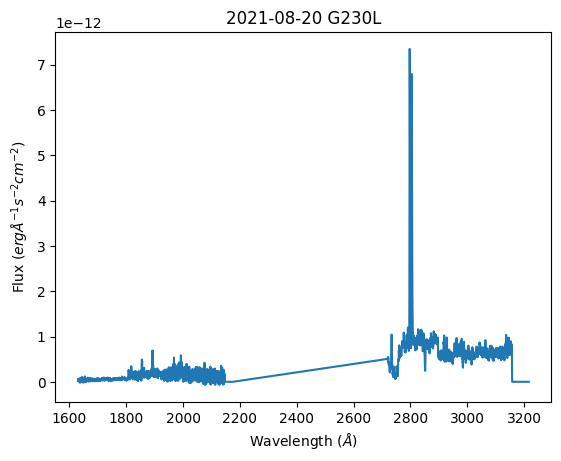

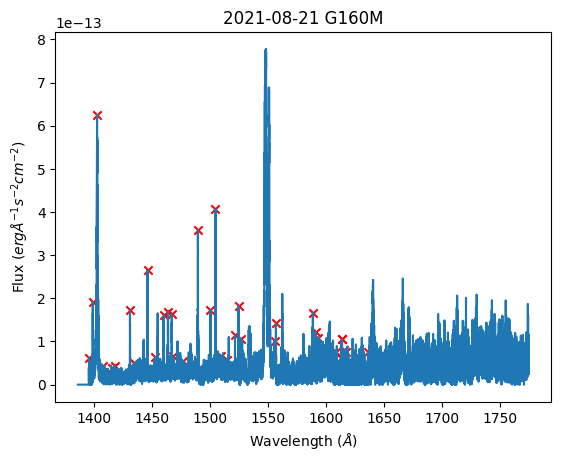

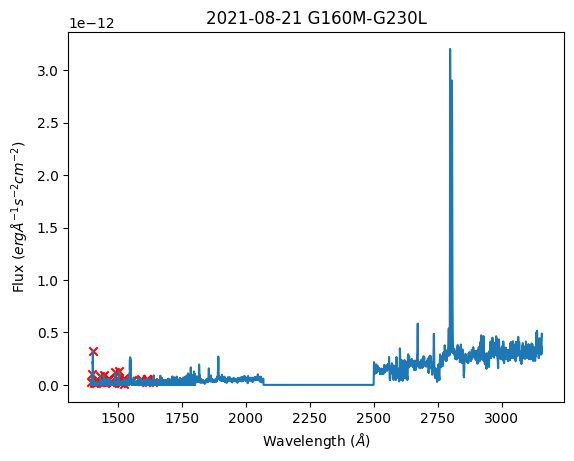

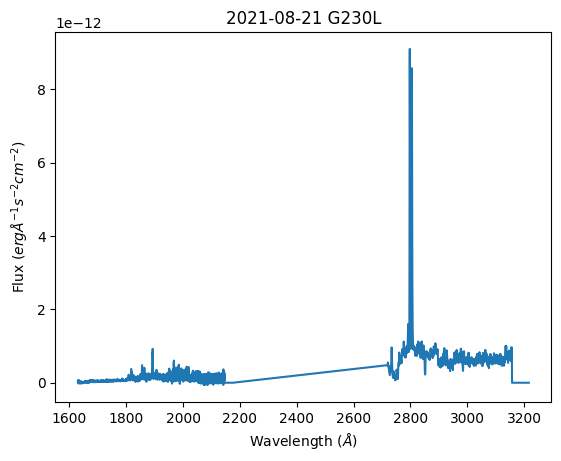

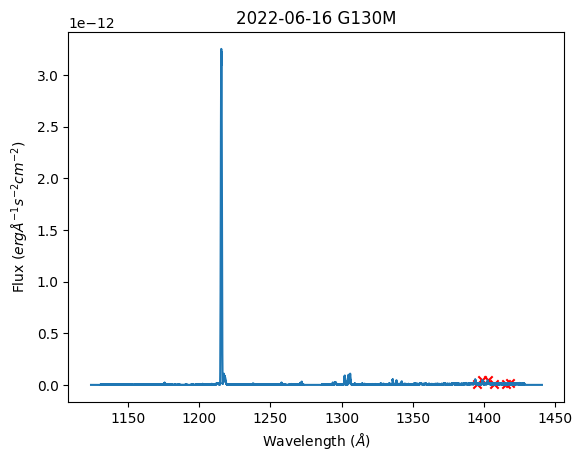

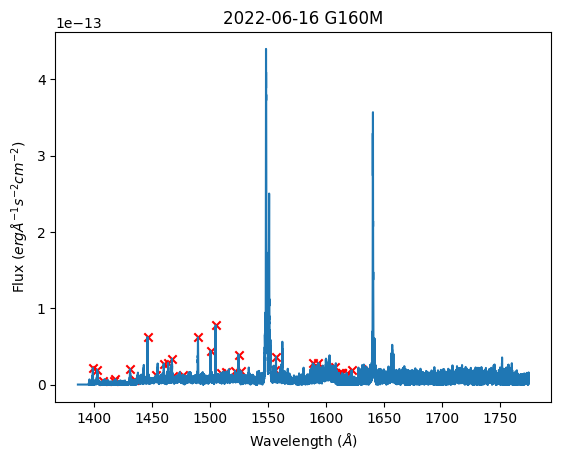

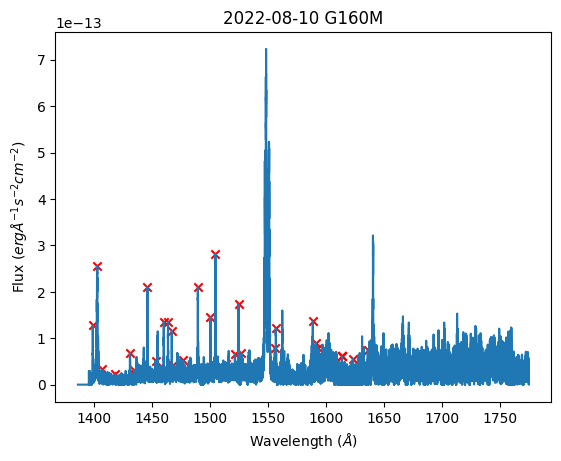

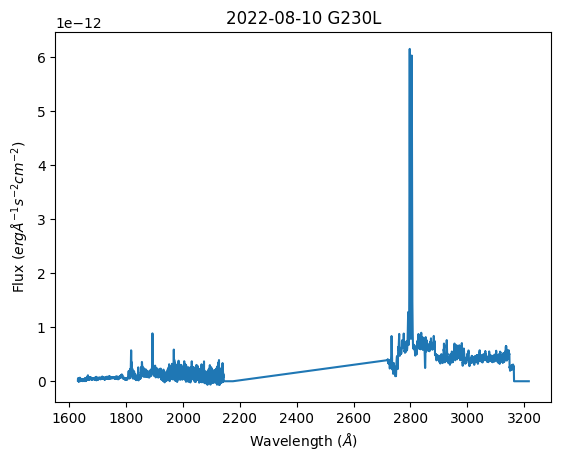

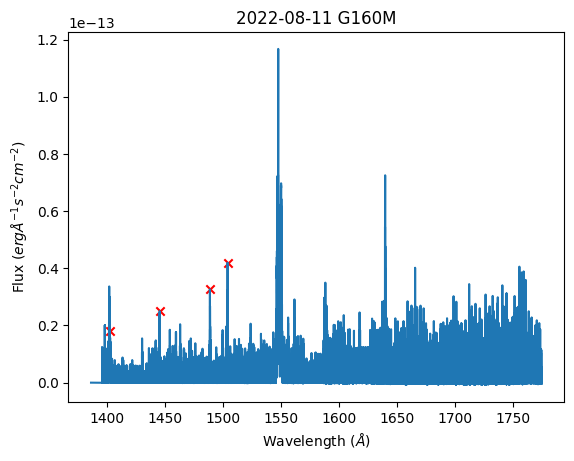

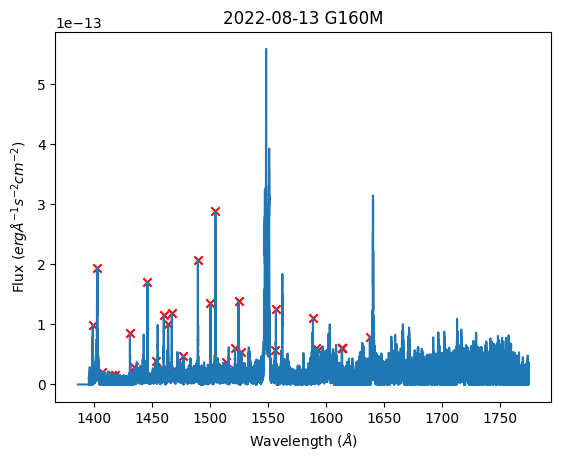

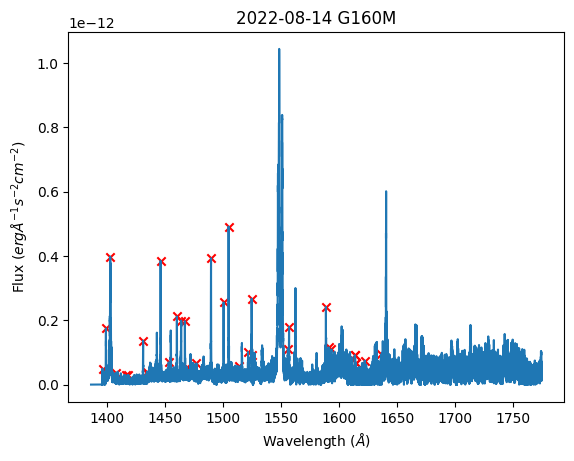

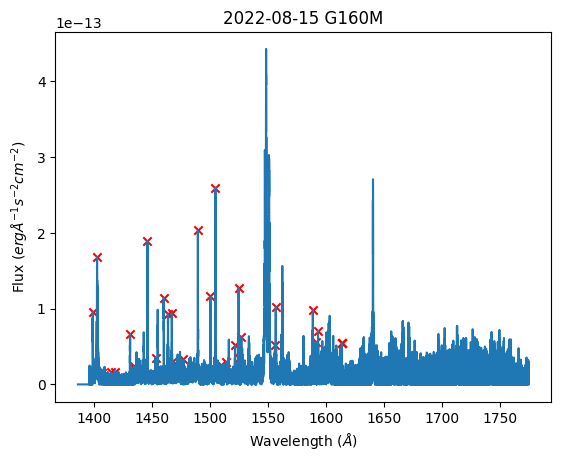

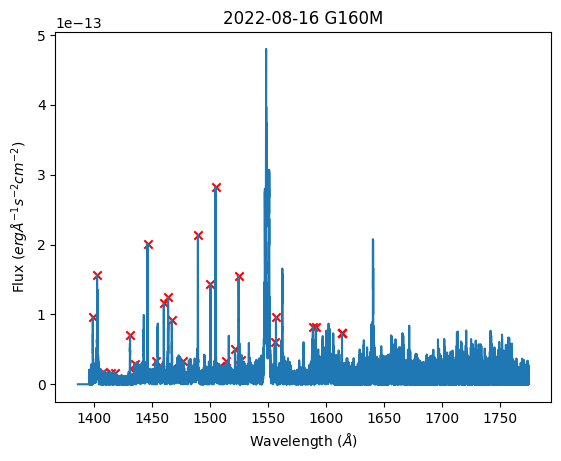

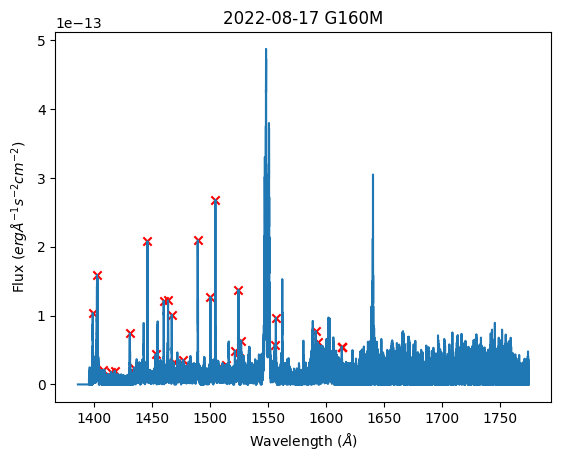

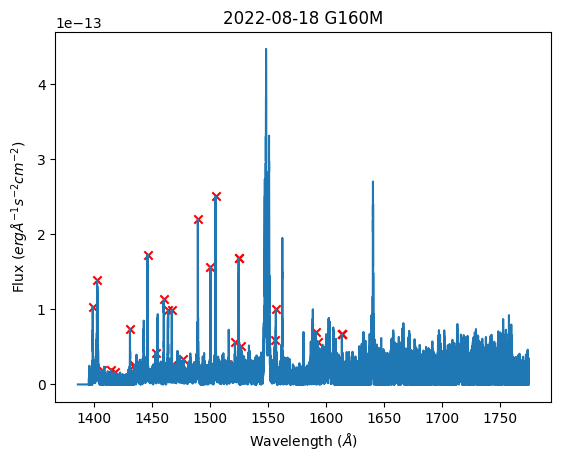

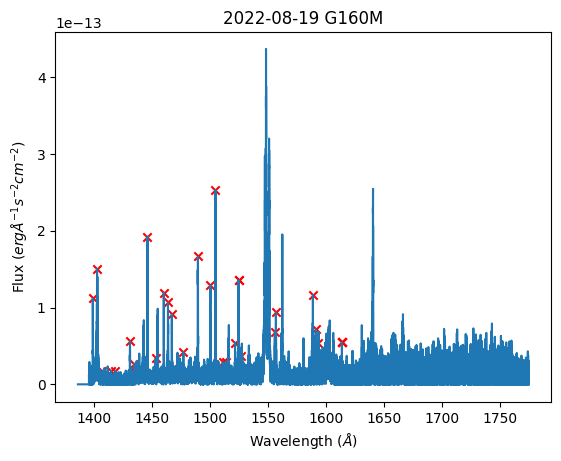

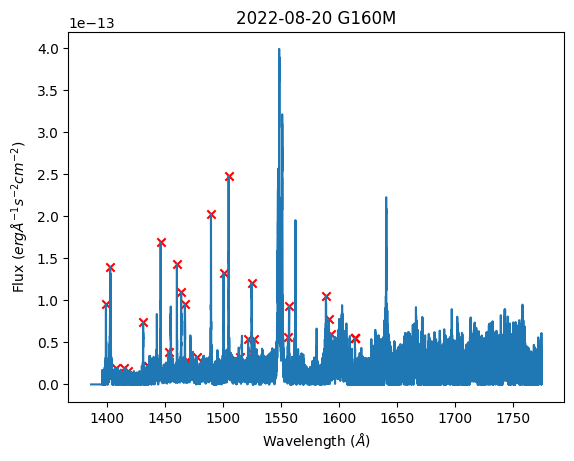

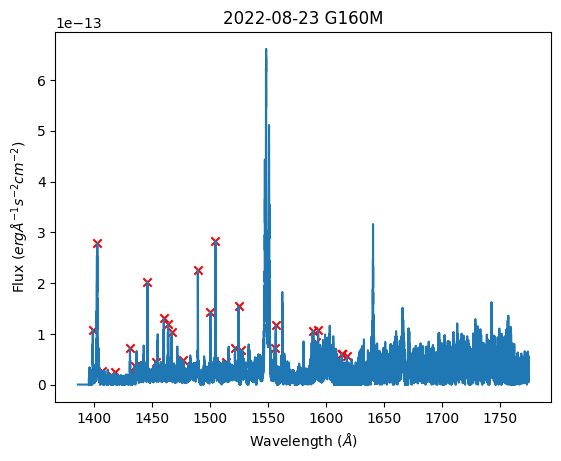

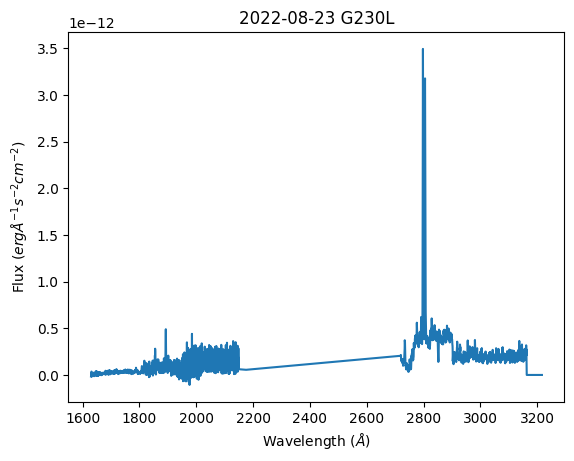

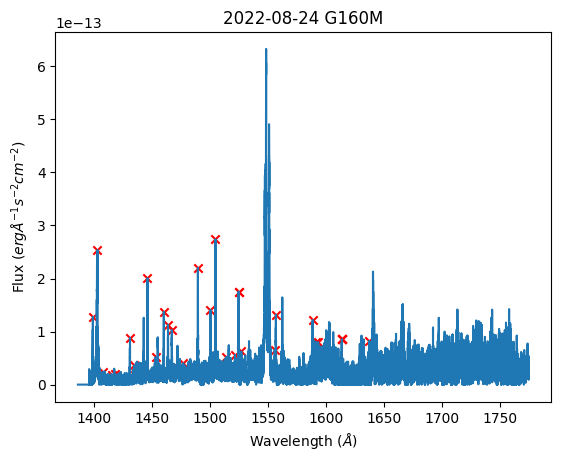

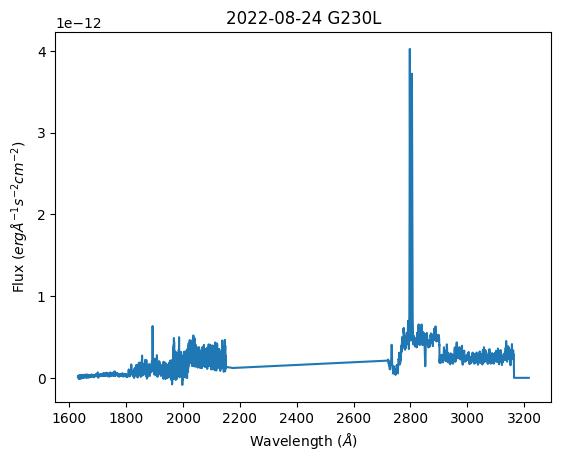

In [479]:
for _, row in stacked_df.iterrows():
    plt.plot(row['wavelength'], row['flux'])
    plt.scatter(row['wavelength'][row['H2line_idx']], row['flux'][row['H2line_idx']], c='r', marker='x')
    plt.title(row['obsdate']+' '+row['filter'])
    plt.xlabel(r'Wavelength ($\AA$)')
    plt.ylabel(r'Flux ($erg \AA^{-1} s^{-2} cm^{-2}$)')
    plt.show()

# Now investigate individual lines

In [293]:
stacked_df = stacked_df.loc[stacked_df['filter']!='G230L']
stacked_df = stacked_df[stacked_df["[nu', J']"].notna()]
stacked_df

,obsdate,filter,wavelength,flux,fluxerr,H2line_idx,"[nu', J']"
0,2011-07-20,G130M,"[1124.7185766387568 Angstrom, 1124.72853832954...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[31744, 28522, 28891, 28159, 29353]","[[1,4], [0,1], [0,2], [0,3], [0,3]]"
1,2011-07-20,G160M,"[1386.0412954067515 Angstrom, 1386.05353027634...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[10072, 17936, 11521, 6621, 9356, 11336, 13958...","[[4,13], [3,16], [4,4], [1,7], [1,7], [1,7], [..."
2,2012-02-28,G130M,"[1124.9096635174221 Angstrom, 1124.91962690073...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[30139, 30456, 31739, 32095, 28467, 28891, 320...","[[4,13], [3,16], [1,4], [3,0], [0,1], [0,2], [..."
3,2012-02-28,G160M,"[1386.2769487823698 Angstrom, 1386.28918573199...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19178, 19697, 2391, 10081, 19629, 2578, 10459...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16..."
4,2021-08-10,G160M,"[1385.9946471407397 Angstrom, 1386.00688689571...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19597, 2424, 10078, 19597, 2620, 10481, 17913...","[[3,13], [4,13], [4,13], [4,13], [3,16], [3,16..."
7,2021-08-12,G160M,"[1385.9934968299058 Angstrom, 1386.00573657483...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19021, 19603, 2360, 10072, 19603, 2626, 10489...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16..."
9,2021-08-13,G160M,"[1385.9931276253203 Angstrom, 1386.00536736705...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19154, 19602, 2390, 10088, 19602, 2614, 10433...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16..."
11,2021-08-14,G160M,"[1385.9926535426373 Angstrom, 1386.00489328013...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19609, 2407, 10068, 19609, 2658, 10486, 17944...","[[3,13], [4,13], [4,13], [4,13], [3,16], [3,16..."
13,2021-08-15,G160M,"[1385.9921658835162 Angstrom, 1386.00440561677...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19151, 19598, 2387, 10090, 19598, 2654, 10446...","[[3,13], [3,13], [4,13], [4,13], [4,13], [3,16..."
15,2021-08-16,G160M,"[1385.9916804390439 Angstrom, 1386.00392016811...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[0.0 erg / (Angstrom s cm2), 0.0 erg / (Angstr...","[19600, 2366, 10075, 19600, 2628, 10439, 17918...","[[3,13], [4,13], [4,13], [4,13], [3,16], [3,16..."


In [382]:
len(list(set(linelist['[nu\', J\']'])))

12

In [ ]:
line_width = 150
transitions = set(linelist['[nu\', J\']'])
line_dict = {'transition': [],
             'obsdate': [],
             'wavelength': [],
             'flux': [],
             'fluxerr': []}
for target_nuJ in transitions:
    for _, row in stacked_df.iterrows():
        if target_nuJ in row["[nu', J']"]:
            targ_idx = np.where(np.array(row["[nu', J']"])==target_nuJ)[0]
            line_idx = np.array(row.loc['H2line_idx'])[targ_idx]

            for i, l in enumerate(line_idx):
                line_dict['wavelength'].append(row['wavelength'][l-line_width:l+line_width])
                line_dict['flux'].append(row['flux'][l-line_width:l+line_width])
                line_dict['fluxerr'].append(row['fluxerr'][l-line_width:l+line_width])
                line_dict['obsdate'].append(row['obsdate'])
                line_dict['transition'].append(target_nuJ)
        else:
            pass

In [ ]:
line_df = pd.DataFrame(line_dict)
line_df

,transition,obsdate,wavelength,flux,fluxerr
0,"[3,13]",2012-02-28,"[1606.841641580529 Angstrom, 1606.853882906185...","[9.607757024062384e-15 erg / (Angstrom s cm2),...","[4.776865877230319e-15 erg / (Angstrom s cm2),..."
1,"[3,13]",2012-02-28,"[1613.1948895963 Angstrom, 1613.2071309219566 ...",[5.0278208186784727e-14 erg / (Angstrom s cm2)...,"[9.783025507519551e-15 erg / (Angstrom s cm2),..."
2,"[3,13]",2021-08-10,"[1611.6918996621785 Angstrom, 1611.70414724122...",[-5.612276857617954e-17 erg / (Angstrom s cm2)...,[1.2131195706180722e-14 erg / (Angstrom s cm2)...
3,"[3,13]",2021-08-12,"[1604.6360080455331 Angstrom, 1604.64825561452...",[4.3446130718106125e-14 erg / (Angstrom s cm2)...,"[2.45931344369239e-14 erg / (Angstrom s cm2), ..."
4,"[3,13]",2021-08-12,"[1611.764093200788 Angstrom, 1611.776340769783...",[-9.066961613487701e-17 erg / (Angstrom s cm2)...,[1.2133239596682447e-14 erg / (Angstrom s cm2)...
...,...,...,...,...,...
829,"[4,4]",2022-08-23,"[1524.9103776271336 Angstrom, 1524.92261733804...",[3.7551156032347256e-14 erg / (Angstrom s cm2)...,[1.4460357455580878e-14 erg / (Angstrom s cm2)...
830,"[4,4]",2022-08-23,"[1611.7596396561269 Angstrom, 1611.77188719108...",[1.2159086807067912e-14 erg / (Angstrom s cm2)...,[1.6675598618967613e-14 erg / (Angstrom s cm2)...
831,"[4,4]",2022-08-24,"[1474.9844057319613 Angstrom, 1474.99664544145...",[2.3178931840959493e-14 erg / (Angstrom s cm2)...,[1.2201933117898796e-14 erg / (Angstrom s cm2)...
832,"[4,4]",2022-08-24,"[1524.9958587337796 Angstrom, 1525.00809844327...","[5.094617636835759e-14 erg / (Angstrom s cm2),...",[1.6047254360845385e-14 erg / (Angstrom s cm2)...


In [458]:
len(line_df['transition'].unique())

12

In [ ]:
line_df['obsdate'].unique()

25

In [447]:
results = {}

# Get all unique combinations of transition and obsdate
combinations = line_df[['obsdate', 'transition']].drop_duplicates()

for _, row in combinations.iterrows():
    date = row['obsdate']
    transition = row['transition']

    # Filter the group
    group = line_df[(line_df['obsdate'] == date) & (line_df['transition'] == transition)]

    result = all_spectra.coaddwave(group)
    results[(date, transition)] = result

In [452]:
result_df = pd.DataFrame([
    {'obsdate': k[0], 'transition': k[1], **(v if v is not None else {})}
    for k, v in results.items()
])
result_df

,obsdate,transition,wavelength,flux,fluxerr
0,2012-02-28,"[3,13]","[1606.841641580529 Angstrom, 1606.853882906185...","[9.607757024062384e-15 erg / (Angstrom s cm2),...","[4.776865877230319e-15 erg / (Angstrom s cm2),..."
1,2021-08-10,"[3,13]","[1611.6918996621785 Angstrom, 1611.70414724122...",[-5.612276857617954e-17 erg / (Angstrom s cm2)...,[1.2131195706180722e-14 erg / (Angstrom s cm2)...
2,2021-08-12,"[3,13]","[1604.6360080455331 Angstrom, 1604.64825561452...",[4.3446130718106125e-14 erg / (Angstrom s cm2)...,"[2.45931344369239e-14 erg / (Angstrom s cm2), ..."
3,2021-08-13,"[3,13]","[1606.2644933086146 Angstrom, 1606.27674087441...",[3.8165775999279524e-14 erg / (Angstrom s cm2)...,[2.3624992193735032e-14 erg / (Angstrom s cm2)...
4,2021-08-14,"[3,13]","[1611.8366137094092 Angstrom, 1611.84886127096...",[-4.529181452792045e-17 erg / (Angstrom s cm2)...,"[1.213357502172956e-14 erg / (Angstrom s cm2),..."
...,...,...,...,...,...
282,2022-08-18,"[4,4]","[1475.0961501367442 Angstrom, 1475.10838985934...","[2.032834927700113e-14 erg / (Angstrom s cm2),...",[1.2276937044836066e-14 erg / (Angstrom s cm2)...
283,2022-08-19,"[4,4]","[1475.132554696137 Angstrom, 1475.144794416120...","[2.966090321093126e-15 erg / (Angstrom s cm2),...","[8.467835365323703e-15 erg / (Angstrom s cm2),..."
284,2022-08-20,"[4,4]","[1475.1199710420267 Angstrom, 1475.13221075928...",[2.0516867174695188e-14 erg / (Angstrom s cm2)...,[1.2421889849562013e-14 erg / (Angstrom s cm2)...
285,2022-08-23,"[4,4]","[1475.0090762369007 Angstrom, 1475.02131594781...",[1.9058588550112788e-14 erg / (Angstrom s cm2)...,[1.1366325600930201e-14 erg / (Angstrom s cm2)...


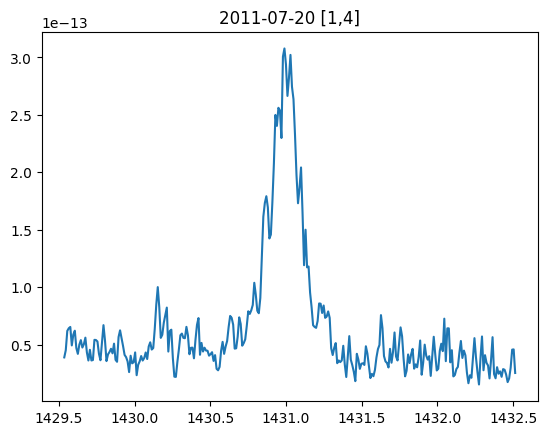

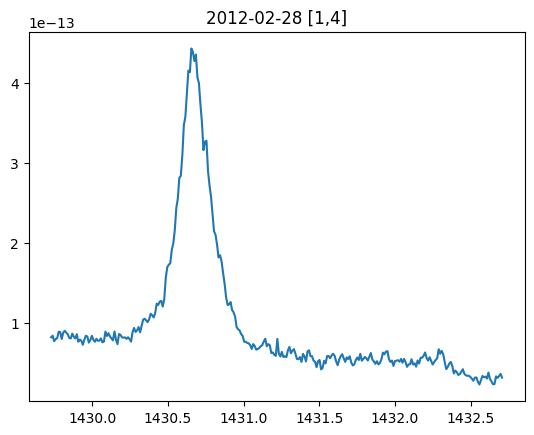

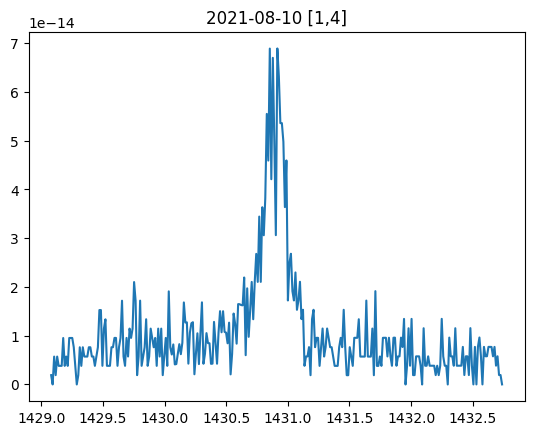

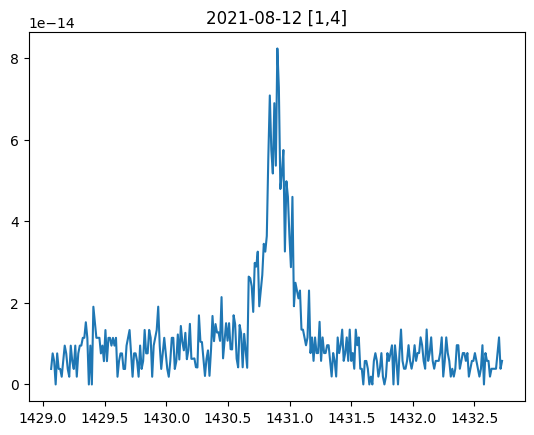

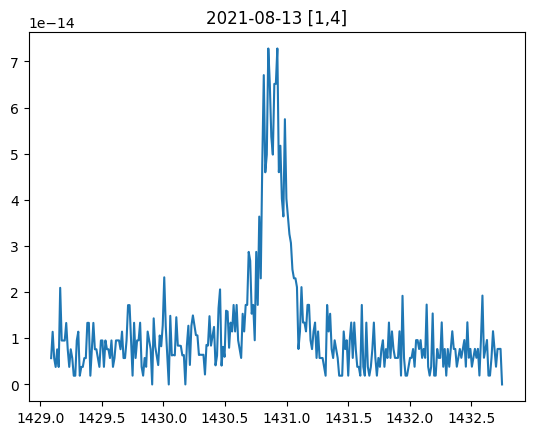

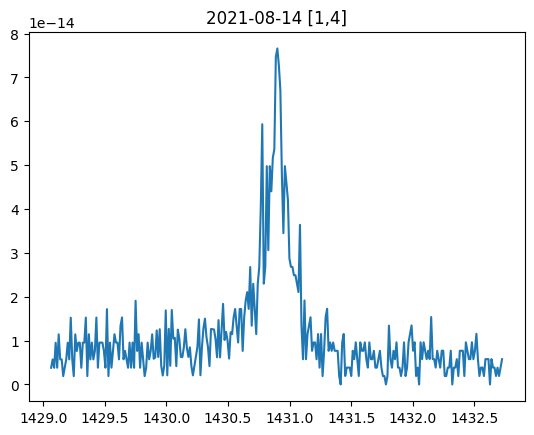

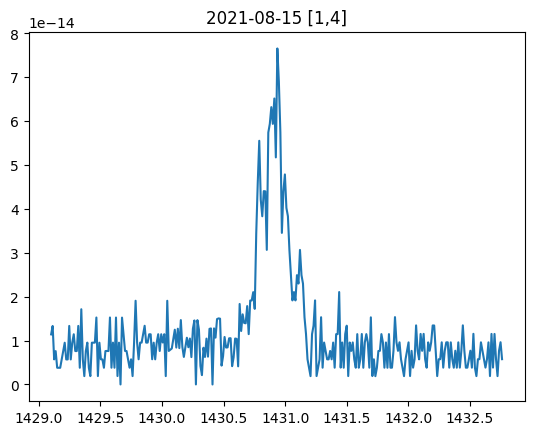

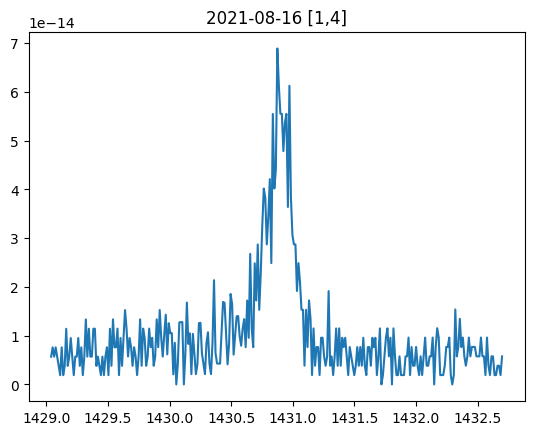

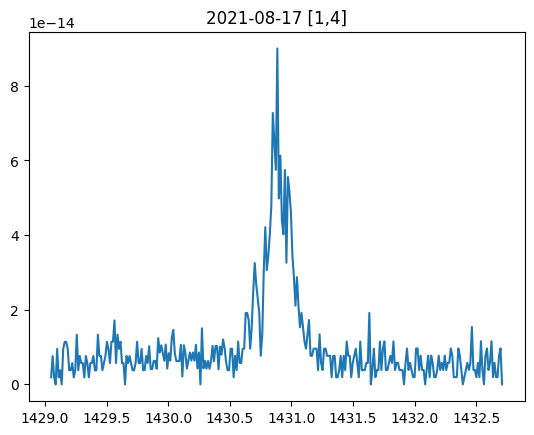

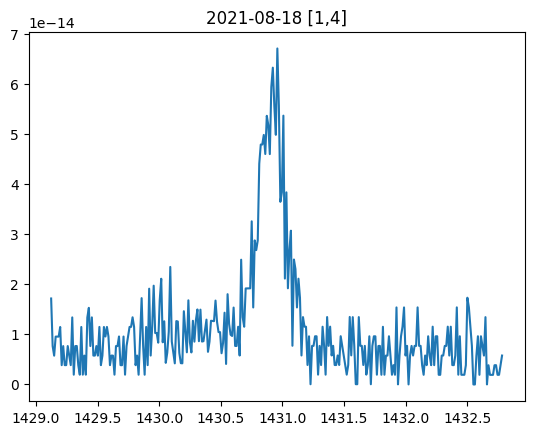

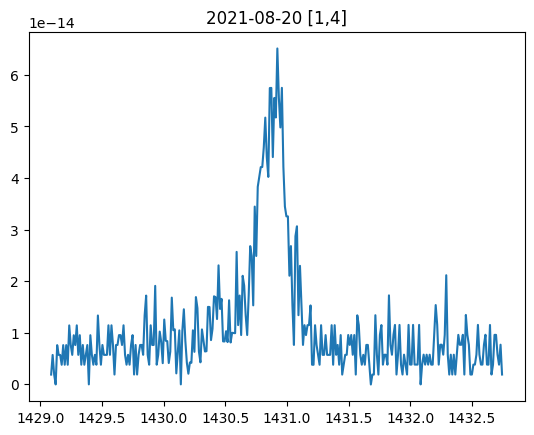

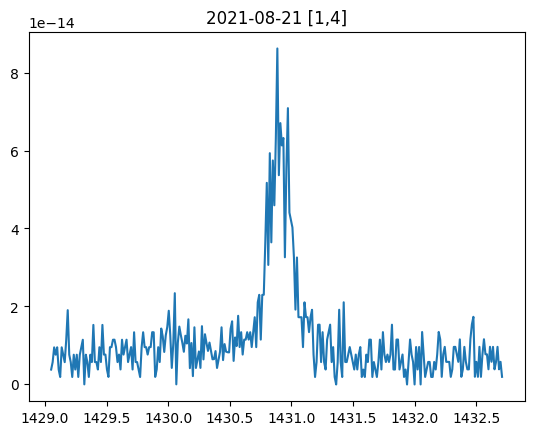

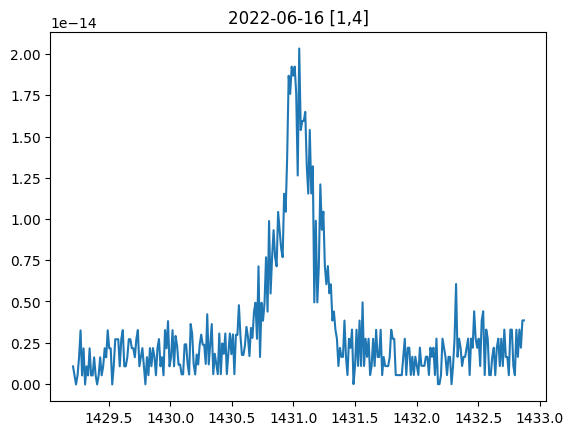

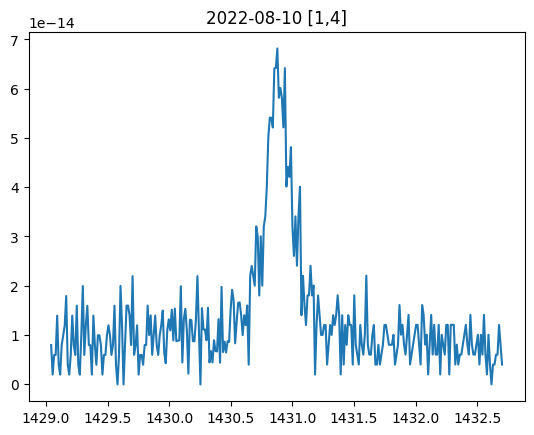

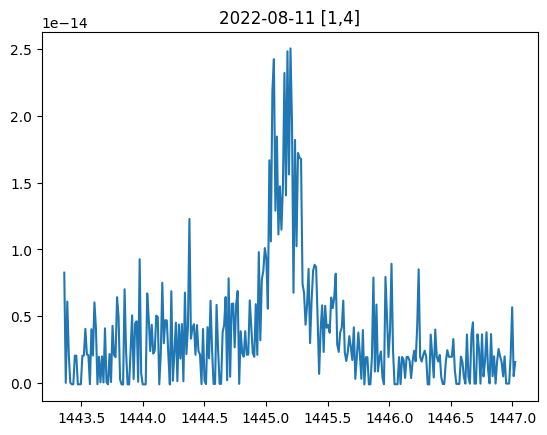

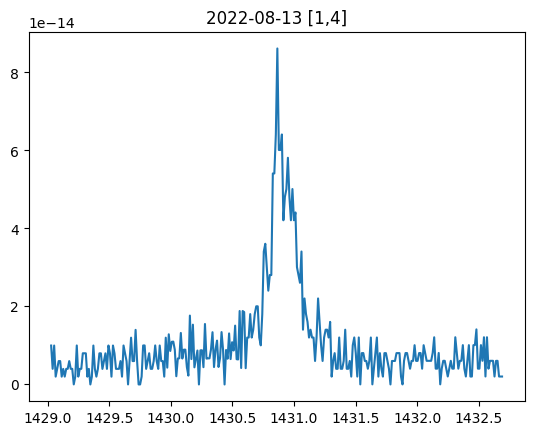

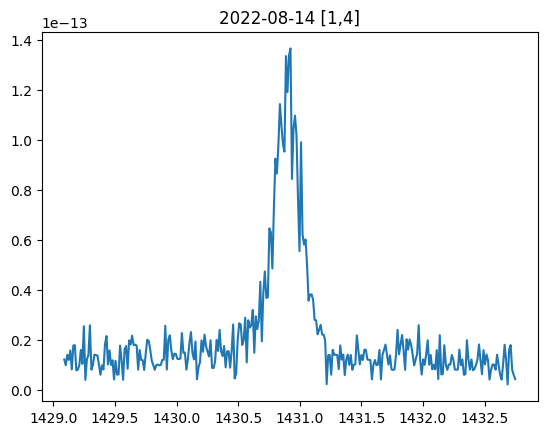

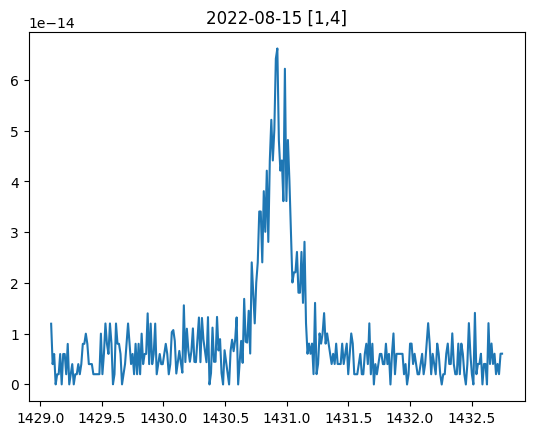

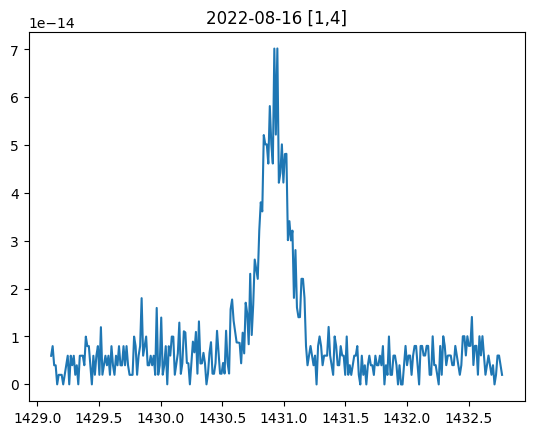

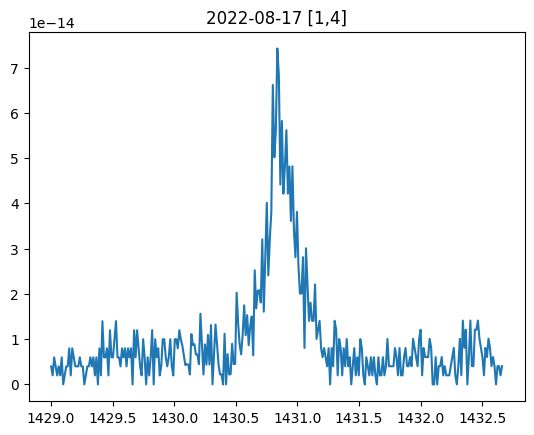

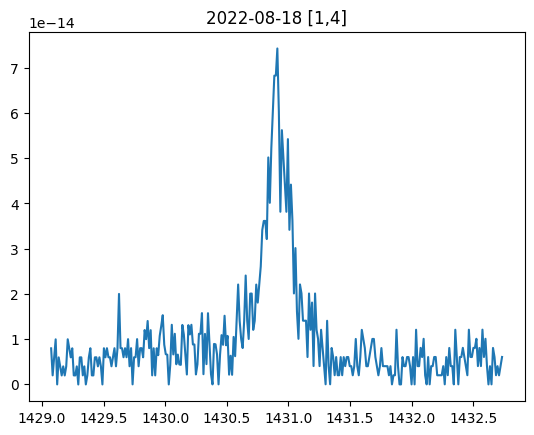

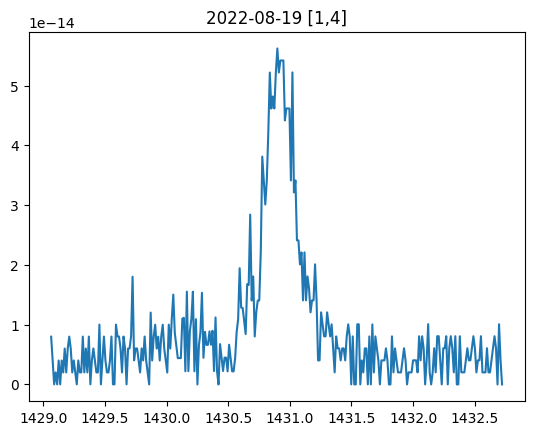

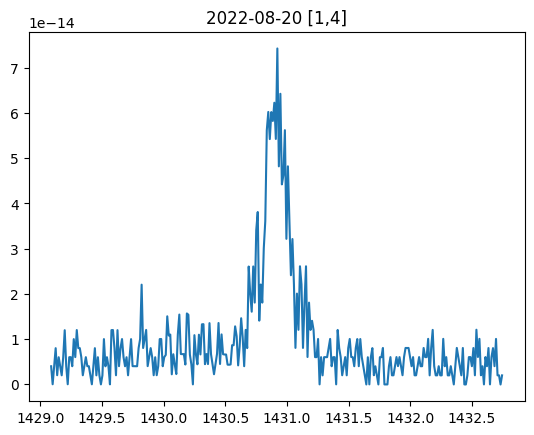

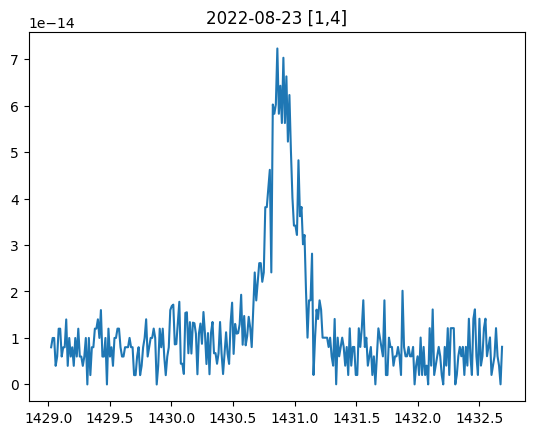

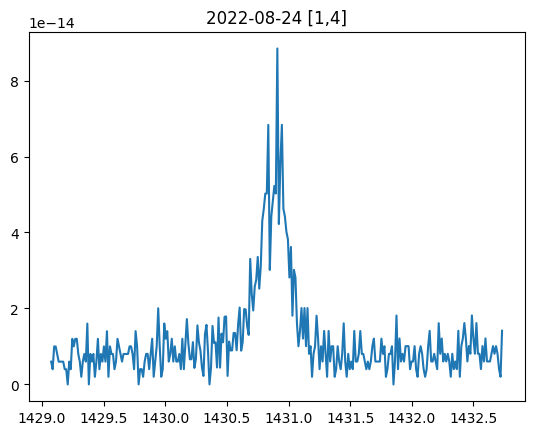

In [461]:
mask = result_df['transition']=='[1,4]'

for _, row in result_df[mask].iterrows():
    plt.plot(row['wavelength'], row['flux'])
    plt.title(row['obsdate']+' '+row['transition'])
    plt.show()